# Materials & Methods

## Prepare environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!git clone "https://github.com/sunwucheng/IDB_drilling_signal.git" /content/drive/MyDrive/IDB_drilling_signal
!nvidia-smi

Mounted at /content/drive
Cloning into '/content/drive/MyDrive/IDB_drilling_signal'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 120 (delta 10), reused 37 (delta 7), pack-reused 75
Receiving objects: 100% (120/120), 153.31 MiB | 16.78 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Updating files: 100% (66/66), done.
Mon Apr 17 11:02:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+===

## Display signal data

### Load signal data

In [2]:
import numpy as np
import scipy.io as scio

def read_matFile(signal_path):
  signal_file = scio.loadmat(signal_path)
  signal_value = signal_file['samples']
  signal_value = np.squeeze(signal_value)
  return signal_value

def read_wavFile(signal_path):
  signal_rate, signal_value = scio.wavfile.read(signal_path)
  return signal_value, signal_rate

import librosa

def read_soundFile(signal_path):
  signal_value, signal_rate = librosa.load(signal_path, sr=None, mono=True, offset=0.0, duration=None)
  return signal_value, signal_rate

In [3]:
RATE = 8192
print("RATE: ", RATE, "Hz (default in Matlab)")

S32h = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment1/3-2h.mat")
S41h = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment1/4-1h.mat")
S42h = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment1/4-2h.mat")
S43b = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment1/4-3b.mat")
print("---------------------------------------")
print("S32h : ", S32h.shape, len(S32h)/RATE, 's')
print("S41h : ", S41h.shape, len(S41h)/RATE, 's')
print("S42h : ", S42h.shape, len(S42h)/RATE, 's')
print("S43b : ", S43b.shape, len(S43b)/RATE, 's')

# S11 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/1_1.mat")
# S12 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/1_2.mat")
# S13 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/1_3.mat")
# S14 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/1_4.mat")
# S15 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/1_5.mat")
# S16 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/1_6.mat")
# S17 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/1_7.mat")
# S18 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/1_8.mat")
# S19 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/1_9.mat")
# print("---------------------------------------")
# print("S11 : ", S11.shape, len(S11)/RATE, 's')
# print("S12 : ", S12.shape, len(S12)/RATE, 's')
# print("S13 : ", S13.shape, len(S13)/RATE, 's')
# print("S14 : ", S14.shape, len(S14)/RATE, 's')
# print("S15 : ", S15.shape, len(S15)/RATE, 's')
# print("S16 : ", S16.shape, len(S16)/RATE, 's')
# print("S17 : ", S17.shape, len(S17)/RATE, 's')
# print("S18 : ", S18.shape, len(S18)/RATE, 's')
# print("S19 : ", S19.shape, len(S19)/RATE, 's')

# S21 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/2_1.mat")
# S22 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/2_2.mat")
# S23 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/2_3.mat")
# S24 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/2_4.mat")
# S25 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/2_5.mat")
# S26 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/2_6.mat")
# S27 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/2_7.mat")
# S28 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/2_8.mat")
# S29 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/2_9.mat")
# print("---------------------------------------")
# print("S21 : ", S21.shape, len(S21)/RATE, 's')
# print("S22 : ", S22.shape, len(S22)/RATE, 's')
# print("S23 : ", S23.shape, len(S23)/RATE, 's')
# print("S24 : ", S24.shape, len(S24)/RATE, 's')
# print("S25 : ", S25.shape, len(S25)/RATE, 's')
# print("S26 : ", S26.shape, len(S26)/RATE, 's')
# print("S27 : ", S27.shape, len(S27)/RATE, 's')
# print("S28 : ", S28.shape, len(S28)/RATE, 's')
# print("S29 : ", S29.shape, len(S29)/RATE, 's')

# S31 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/3_1.mat")
# S32 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/3_2.mat")
# S33 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/3_3.mat")
# S34 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/3_4.mat")
# S35 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/3_5.mat")
# S36 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/3_6.mat")
# S37 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/3_7.mat")
# S38 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/3_8.mat")
# S39 = read_matFile("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/3_9.mat")
# print("---------------------------------------")
# print("S31 : ", S31.shape, len(S31)/RATE, 's')
# print("S32 : ", S32.shape, len(S32)/RATE, 's')
# print("S33 : ", S33.shape, len(S33)/RATE, 's')
# print("S34 : ", S34.shape, len(S34)/RATE, 's')
# print("S35 : ", S35.shape, len(S35)/RATE, 's')
# print("S36 : ", S36.shape, len(S36)/RATE, 's')
# print("S37 : ", S37.shape, len(S37)/RATE, 's')
# print("S38 : ", S38.shape, len(S38)/RATE, 's')
# print("S39 : ", S39.shape, len(S39)/RATE, 's')

RATE:  8192 Hz (default in Matlab)
---------------------------------------
S32h :  (8880128,) 1084.0 s
S41h :  (7216896,) 880.96875 s
S42h :  (11019776,) 1345.1875 s
S43b :  (22244352,) 2715.375 s


### Save data sound

In [4]:
# import soundfile

# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment1/S32h.wav"), S32h, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment1/S41h.wav"), S41h, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment1/S42h.wav"), S42h, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment1/S43b.wav"), S43b, RATE)

# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S11.wav"), S11, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S12.wav"), S12, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S13.wav"), S13, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S14.wav"), S14, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S15.wav"), S15, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S16.wav"), S16, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S17.wav"), S17, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S18.wav"), S18, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S19.wav"), S19, RATE)

# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S21.wav"), S21, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S22.wav"), S22, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S23.wav"), S23, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S24.wav"), S24, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S25.wav"), S25, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S26.wav"), S26, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S27.wav"), S27, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S28.wav"), S28, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S29.wav"), S29, RATE)

# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S31.wav"), S31, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S32.wav"), S32, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S33.wav"), S33, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S34.wav"), S34, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S35.wav"), S35, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S36.wav"), S36, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S37.wav"), S37, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S38.wav"), S38, RATE)
# soundfile.write(("/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment2/S39.wav"), S39, RATE)

### Plot signal data

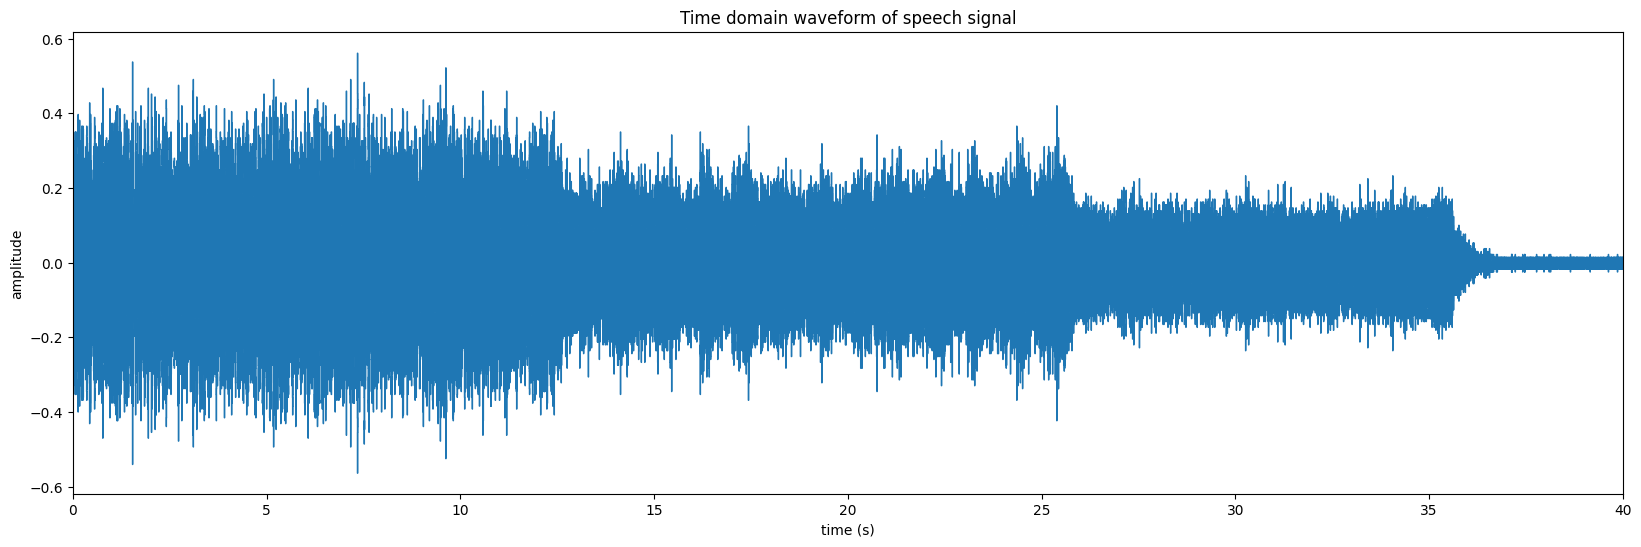

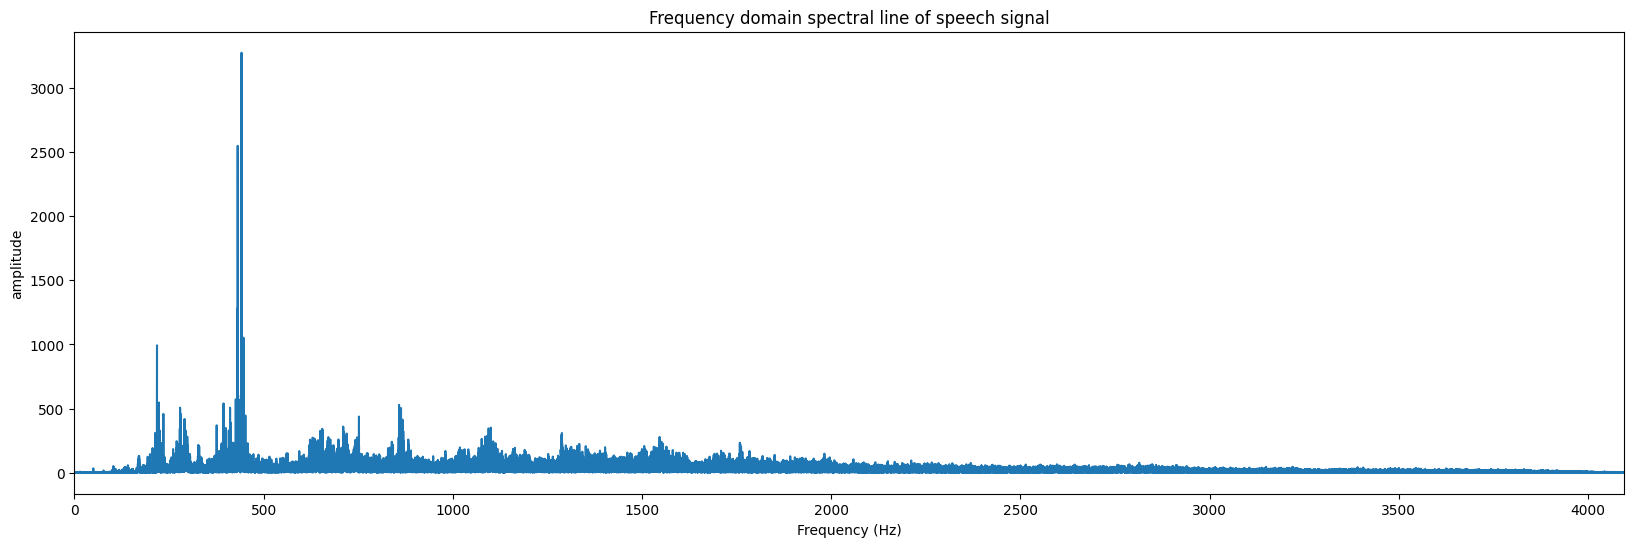

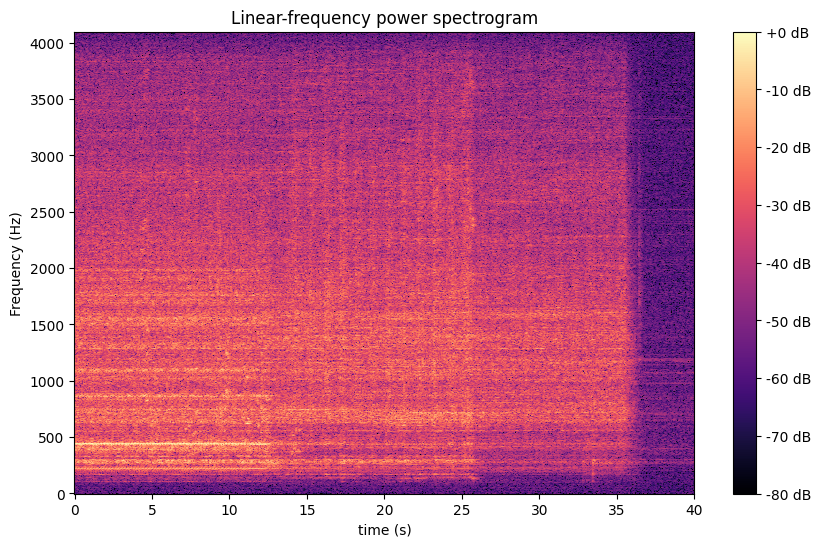

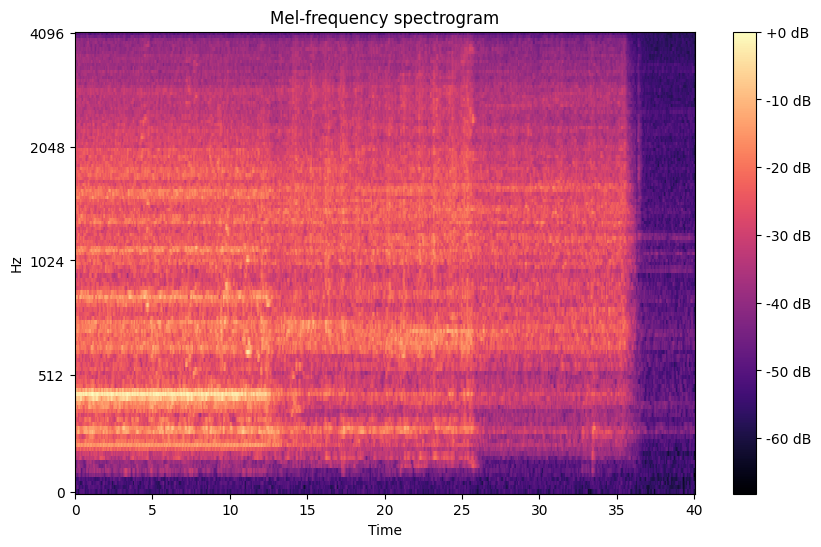

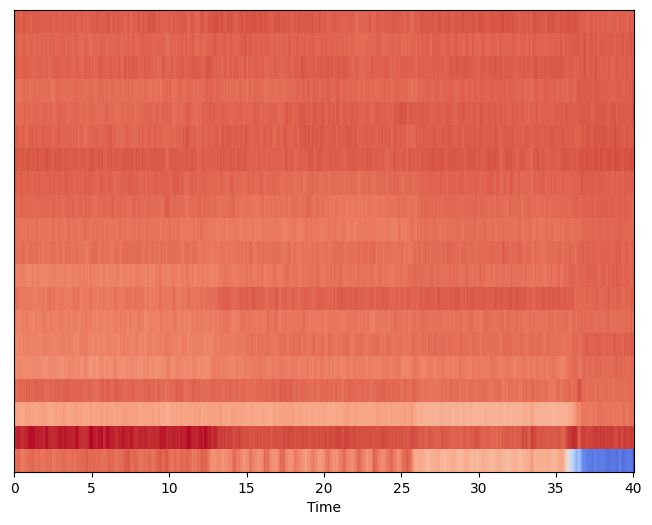

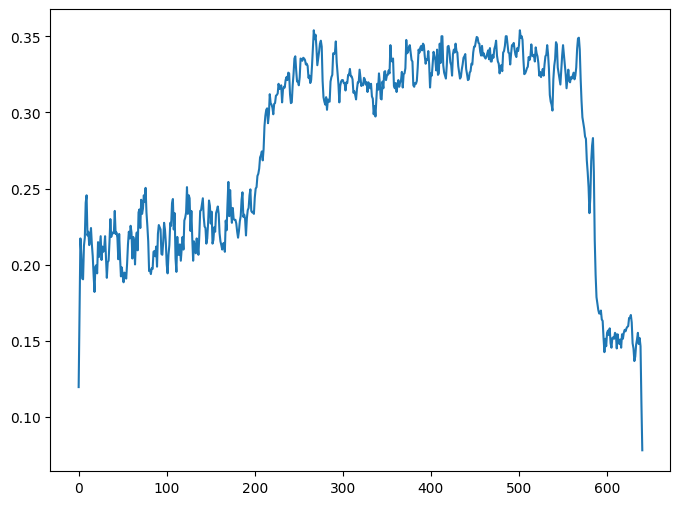

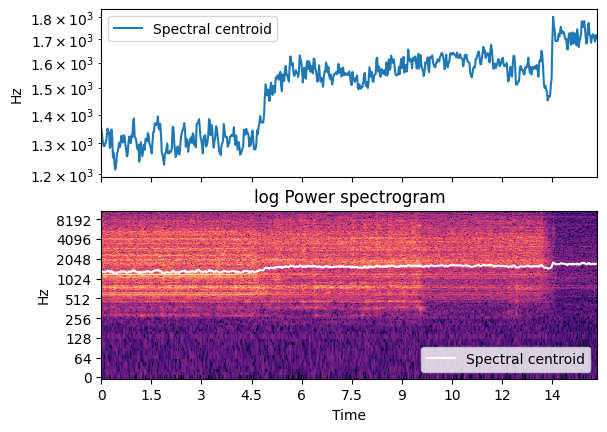

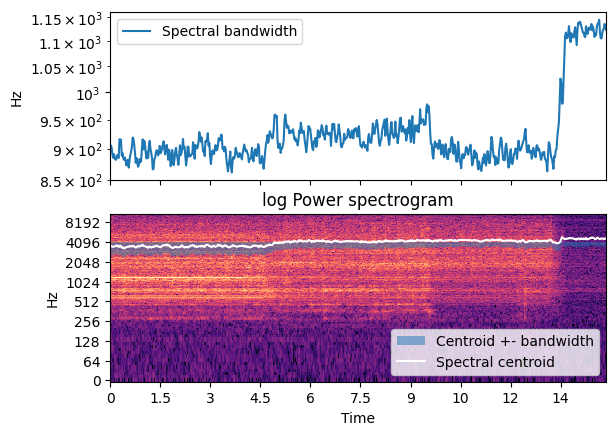

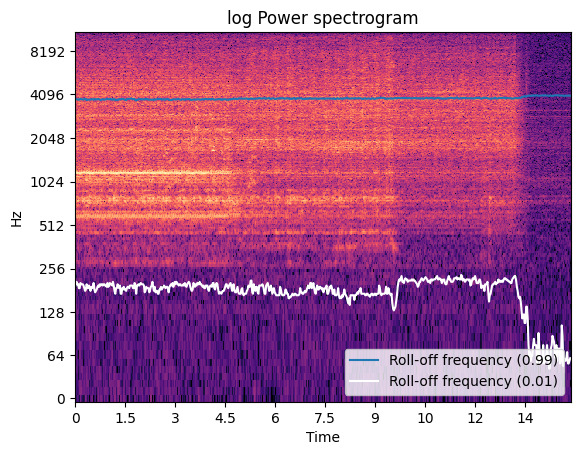

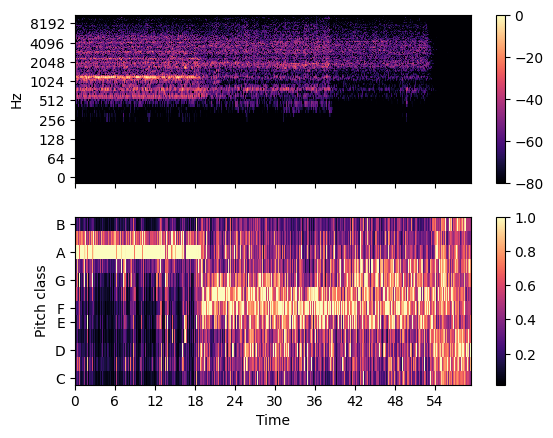

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def displayWaveform(signal, rate):
  plt.figure(figsize=(20,6))
  max = np.max(np.absolute(signal))*1.2
  time = np.arange(0, len(SIGNAL)) / RATE
  # plt.plot(time, signal)
  librosa.display.waveshow(signal, sr=rate)
  plt.title("Time domain waveform of speech signal")
  plt.xlabel("time (s)")
  plt.ylabel("amplitude")
  plt.xlim(0,len(SIGNAL)/RATE)
  ymin, ymax = plt.ylim()
  ylim = np.maximum(np.abs(ymin), np.abs(ymax))
  plt.ylim(-ylim, ylim)

def displaySpectrum(signal, rate):
  plt.figure(figsize=(20,6)) 
  s = np.fft.fft(signal)
  m = np.abs(s)
  # f = np.linspace(0, rate, len(m))
  # plt.plot(f, m)
  n = len(signal)
  f = np.fft.fftfreq(n, 1/rate)
  plt.plot(f[:n//2],m[:n//2])
  plt.title("Frequency domain spectral line of speech signal")
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("amplitude")
  plt.xlim(0, rate//2)

def displaySpectrogram(signal, rate, fftlen):    
  plt.figure(figsize=(10,6))
  # plt.specgram(signal, NFFT=fftlen, Fs=rate, noverlap=int(fftlen*0.25), window=np.hanning(fftlen))
  signal_db = librosa.amplitude_to_db(np.abs(librosa.stft(signal, hop_length=int(fftlen*0.25))), ref=np.max) 
  librosa.display.specshow(signal_db, sr=rate, hop_length=int(fftlen*0.25), x_axis='time', y_axis='linear')
  plt.title('Linear-frequency power spectrogram')
  plt.xlabel('time (s)')
  plt.ylabel('Frequency (Hz)')
  plt.colorbar(format="%+2.0f dB")

def displayMelspectrogram(signal, rate):
  plt.figure(figsize=(10,6))
  # melspectrogram = librosa.feature.melspectrogram(y=signal, sr=rate)
  D = np.abs(librosa.stft(signal))**2
  S = librosa.feature.melspectrogram(S=D, sr=rate)
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, sr=rate, fmax=rate/2, x_axis='time', y_axis='mel') 
  plt.title('Mel-frequency spectrogram')
  plt.colorbar(format='%+2.0f dB')

def diaplayMFCC(signal, rate):
  plt.figure(figsize=(8,6))
  mfccs = librosa.feature.mfcc(y=signal, sr=rate)
  librosa.display.specshow(mfccs, sr=rate, x_axis='time')

def displayZCR(signal, rate):
  plt.figure(figsize=(8,6))
  zcrs = librosa.feature.zero_crossing_rate(signal)  
  plt.plot(zcrs[0])

from sklearn import preprocessing
def normalize(x, axis=0):
    return preprocessing.minmax_scale(x, axis=axis)

def displayCentroids(signal, rate):
  # spectral_centroids = librosa.feature.spectral_centroid(y=signal, sr=rate)[0]
  # frames = range(len(spectral_centroids))
  # times = librosa.frames_to_time(frames)
  # librosa.display.waveshow(signal, sr=rate, alpha=0.4)
  # plt.plot(times, normalize(spectral_centroids), color='r')

  cent = librosa.feature.spectral_centroid(y=signal, sr=rate) 
  S, phase = librosa.magphase(librosa.stft(y=signal))
  S_db = librosa.amplitude_to_db(S, ref=np.max)
  librosa.feature.spectral_centroid(S=S)
  freqs, times, D = librosa.reassigned_spectrogram(signal, fill_nan=True)
  librosa.feature.spectral_centroid(S=np.abs(D), freq=freqs)
  times = librosa.times_like(cent)

  fig, ax = plt.subplots(nrows=2, sharex=True)
  ax[0].semilogy(times, cent[0], label='Spectral centroid')
  ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
  ax[0].legend()
  ax[0].label_outer()

  librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax[1])
  ax[1].plot(times, cent.T, label='Spectral centroid', color='w')
  ax[1].set(title='log Power spectrogram')
  ax[1].legend(loc='lower right')

def displayBandwidth(signal, rate):
  # spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y=signal+0.01, sr=rate)[0]
  # spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y=signal+0.01, sr=rate, p=3)[0]
  # spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y=signal+0.01, sr=rate, p=4)[0]
  # librosa.display.waveshow(signal, sr=rate, alpha=0.4)
  # normal2 = preprocessing.minmax_scale(spectral_bandwidth_2, axis=0)
  # normal3 = preprocessing.minmax_scale(spectral_bandwidth_3, axis=0)
  # normal4 = preprocessing.minmax_scale(spectral_bandwidth_4, axis=0)
  # spectral_centroids = librosa.feature.spectral_centroid(y=signal, sr=rate)[0]
  # frames = range(len(spectral_centroids))
  # times = librosa.frames_to_time(frames)
  # plt.plot(times, normal2, color='r')
  # plt.plot(times, normal3, color='g')
  # plt.plot(times, normal4, color='y')
  # plt.legend(('p = 2', 'p = 3', 'p = 4'))

  spec_bw = librosa.feature.spectral_bandwidth(y=signal, sr=rate)
  S, phase = librosa.magphase(librosa.stft(y=signal))
  S_db = librosa.amplitude_to_db(S, ref=np.max)
  librosa.feature.spectral_bandwidth(S=S)
  freqs, times, D = librosa.reassigned_spectrogram(signal, fill_nan=True)
  librosa.feature.spectral_bandwidth(S=np.abs(D), freq=freqs)
  times = librosa.times_like(spec_bw)
  centroid = librosa.feature.spectral_centroid(S=S)

  fig, ax = plt.subplots(nrows=2, sharex=True)
  ax[0].semilogy(times, spec_bw[0], label='Spectral bandwidth')
  ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
  ax[0].legend()
  ax[0].label_outer()

  librosa.display.specshow(S_db, y_axis='log', x_axis='time', ax=ax[1])
  ax[1].set(title='log Power spectrogram')
  ax[1].fill_between(times, np.maximum(0, centroid[0] - spec_bw[0]), np.minimum(centroid[0] + spec_bw[0], rate/2), alpha=0.5, label='Centroid +- bandwidth')
  ax[1].plot(times, centroid[0], label='Spectral centroid', color='w')
  ax[1].legend(loc='lower right')

def displayRolloff(signal, rate):
  # spectral_rolloff = librosa.feature.spectral_rolloff(y=signal+0.01, sr=rate)[0]
  # librosa.display.waveshow(signal, sr=rate, alpha=0.4)
  # spectral_centroids = librosa.feature.spectral_centroid(y=signal, sr=rate)[0]
  # frames = range(len(spectral_centroids))
  # times = librosa.frames_to_time(frames)
  # normals = preprocessing.minmax_scale(spectral_rolloff, axis=0)
  # plt.plot(times, normals, color='r')

  librosa.feature.spectral_rolloff(y=signal, sr=rate)
  rolloff = librosa.feature.spectral_rolloff(y=signal, sr=rate, roll_percent=0.99)
  rolloff_min = librosa.feature.spectral_rolloff(y=signal, sr=rate, roll_percent=0.01)
  S, phase = librosa.magphase(librosa.stft(signal))
  S_db = librosa.amplitude_to_db(S, ref=np.max)
  librosa.feature.spectral_rolloff(S=S, sr=rate)
  librosa.feature.spectral_rolloff(y=signal, sr=rate, roll_percent=0.95)

  fig, ax = plt.subplots()
  librosa.display.specshow(S_db, y_axis='log', x_axis='time', ax=ax)
  ax.plot(librosa.times_like(rolloff), rolloff[0], label='Roll-off frequency (0.99)')
  ax.plot(librosa.times_like(rolloff), rolloff_min[0], color='w', label='Roll-off frequency (0.01)')
  ax.legend(loc='lower right')
  ax.set(title='log Power spectrogram')

def displayChromastft(signal, rate, fftlen):
  # plt.figure(figsize=(20, 6))
  # chromagram = librosa.feature.chroma_stft(signal, sr=rate, hop_length=int(fftlen*0.25))
  # librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=fftlen*0.25, cmap='coolwarm')

  S = np.abs(librosa.stft(signal))
  chroma = librosa.feature.chroma_stft(S=S, sr=rate)
  S = np.abs(librosa.stft(signal, n_fft=fftlen))**2
  S_db = librosa.amplitude_to_db(S, ref=np.max)
  chroma = librosa.feature.chroma_stft(S=S, sr=rate)

  fig, ax = plt.subplots(nrows=2, sharex=True)
  img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax[0])
  fig.colorbar(img, ax=[ax[0]])
  ax[0].label_outer()
  img = librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', ax=ax[1])
  fig.colorbar(img, ax=[ax[1]])

def displayChromacqt(signal, rate, n_chroma, n_fft):
  chroma_stft = librosa.feature.chroma_stft(y=signal, sr=rate, n_chroma=n_chroma, n_fft=n_fft)
  chroma_cq = librosa.feature.chroma_cqt(y=signal, sr=rate)

  fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
  img1 = librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma', ax=ax[0])
  ax[0].set(title='chroma_stft')
  ax[0].label_outer()

  img2 = librosa.display.specshow(chroma_cq, x_axis='time', y_axis='chroma', ax=ax[1])
  ax[1].set(title='chroma_cqt')
  fig.colorbar(img2, ax=ax)

def displayChromacens(signal, rate):
  chroma_cens = librosa.feature.chroma_cens(y=signal, sr=rate)
  chroma_cq = librosa.feature.chroma_cqt(y=signal, sr=rate)

  fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
  img1 = librosa.display.specshow(chroma_cq, x_axis='time', y_axis='chroma', ax=ax[0])
  ax[0].set(title='chroma_cq')
  ax[0].label_outer()
  img2 = librosa.display.specshow(chroma_cens, x_axis='time', y_axis='chroma', ax=ax[1])
  ax[1].set(title='chroma_cens')
  fig.colorbar(img1, ax=ax)

def displayChromavqt(signal, rate, n_bins):
  chroma_cq = librosa.feature.chroma_cqt(y=signal, sr=rate, n_chroma=n_bins)
  chroma_vq = librosa.feature.chroma_vqt(y=signal, sr=rate, intervals='ji5', bins_per_octave=n_bins)

  fig, ax = plt.subplots(nrows=2, sharex=True)
  img1 = librosa.display.specshow(chroma_cq, x_axis='time', y_axis='chroma', ax=ax[0], bins_per_octave=n_bins)
  ax[0].set(ylabel='chroma_cqt')
  ax[0].label_outer()

  img2 = librosa.display.specshow(chroma_vq, y_axis='chroma_fjs', x_axis='time', ax=ax[1], bins_per_octave=n_bins, intervals='ji5')
  ax[1].set(ylabel='chroma_vqt')
  fig.colorbar(img2, ax=ax)

def plot_wave(signal, rate):  
  displayWaveform(signal, rate)
  displaySpectrum(signal, rate)
  displaySpectrogram(signal, rate, fftlen=512)
  displayMelspectrogram(signal, rate)
  diaplayMFCC(signal, rate)
  displayZCR(signal, rate)
  displayCentroids(signal, rate)
  displayBandwidth(signal, rate)
  displayRolloff(signal, rate)
  displayChromastft(signal, rate, fftlen=512)
  # displayChromacqt(signal, rate, n_chroma=12, n_fft=512)
  # displayChromacens(signal, rate)
  # displayChromavqt(signal, rate, n_bins=24)

SIGNAL = S32h[-40*RATE:]
plot_wave(SIGNAL, RATE)

import IPython

IPython.display.Audio(data=SIGNAL, rate=RATE)

### Pick signal cut

In [6]:
def cut_signal(signal_series):

  sample_size = int(RATE/2)         # 4096
  sample_step = int(sample_size/4)  # 512
  sample_data = []

  for i in range((len(signal_series)-sample_size) // sample_step):
    sample_data.append(signal_series[i*sample_step : (i*sample_step+sample_size)])

  sample_data = np.stack(sample_data)
  sample_data = np.squeeze(sample_data)

  # np.random.seed(42)
  # np.random.shuffle(sample_data)
  
  return sample_data

# Classification model

### Data pre-treatment

In [7]:
# S32hCX 00:00-17:36 (02:00-12:00)
# S41hCX 01:21-14:03 (02:00-12:00)
# S42hCX 00:00-21:24 (02:00-12:00)
# S43bCX 01:01-37:31 (02:00-12:00 14:00-24:00 26:00-36:00)

S32hCX = cut_signal(S32h[120*RATE:720*RATE])
S41hCX = cut_signal(S41h[120*RATE:720*RATE])
S42hCX = cut_signal(S42h[120*RATE:720*RATE])
S43bCX1 = cut_signal(S43b[120*RATE:720*RATE])
S43bCX2 = cut_signal(S43b[840*RATE:1440*RATE])
S43bCX3 = cut_signal(S43b[1560*RATE:2160*RATE])

print(S32hCX.shape)
print(S41hCX.shape)
print(S42hCX.shape)
print(S43bCX1.shape)
print(S43bCX2.shape)
print(S43bCX3.shape)

S32hCY = np.repeat(0, len(S32hCX))
S41hCY = np.repeat(0, len(S41hCX))
S42hCY = np.repeat(0, len(S42hCX))
S43bCY1 = np.repeat(1, len(S43bCX1))
S43bCY2 = np.repeat(1, len(S43bCX2))
S43bCY3 = np.repeat(1, len(S43bCX3))

print(S32hCY.shape)
print(S41hCY.shape)
print(S42hCY.shape)
print(S43bCY1.shape)
print(S43bCY2.shape)
print(S43bCY3.shape)

(4796, 4096)
(4796, 4096)
(4796, 4096)
(4796, 4096)
(4796, 4096)
(4796, 4096)
(4796,)
(4796,)
(4796,)
(4796,)
(4796,)
(4796,)


In [8]:
X_set = np.concatenate((S32hCX, S41hCX, S42hCX, S43bCX1, S43bCX2, S43bCX3), axis=0)
print(X_set.shape)
X_set = X_set.reshape((X_set.shape[0], X_set.shape[1], 1))
print(X_set.shape)
print(X_set[0])

Y_set = np.concatenate((S32hCY, S41hCY, S42hCY, S43bCY1, S43bCY2, S43bCY3), axis=0)
num_classes = len(np.unique(Y_set))
print(Y_set.shape)
print(Y_set)

from keras.utils.np_utils import to_categorical

Y_set = to_categorical(Y_set, num_classes=num_classes)
print(Y_set.shape)
print(Y_set)

(28776, 4096)
(28776, 4096, 1)
[[-0.2734375]
 [-0.1875   ]
 [-0.171875 ]
 ...
 [-0.0625   ]
 [ 0.0234375]
 [ 0.015625 ]]
(28776,)
[0 0 0 ... 1 1 1]
(28776, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_set, Y_set, test_size=0.33, random_state=42)
print(x_train.shape)
print(x_train[0])
print(x_test.shape)
print(x_test[0])
print(y_train.shape)
print(y_train)
print(y_test.shape)
print(y_test)

(19279, 4096, 1)
[[-0.03125  ]
 [-0.015625 ]
 [ 0.0234375]
 ...
 [-0.0390625]
 [-0.0546875]
 [ 0.       ]]
(9497, 4096, 1)
[[ 0.078125 ]
 [-0.1171875]
 [-0.140625 ]
 ...
 [-0.2734375]
 [-0.1015625]
 [ 0.0390625]]
(19279, 2)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
(9497, 2)
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [10]:
import gc

del S32hCX, S41hCX, S42hCX, S43bCX1, S43bCX2, S43bCX3, S32hCY, S41hCY, S42hCY, S43bCY1, S43bCY2, S43bCY3, X_set, Y_set
gc.collect()

0

In [11]:
from tensorflow import keras

## 1D pure FC model

In [12]:
# def make_model():

#   input_layer = keras.Input(shape=(x_train.shape[1:]))
#   x = keras.layers.Flatten()(input_layer)
#   x = keras.layers.Dense(2048, activation="relu")(x)
#   x = keras.layers.Dense(2048, activation="relu")(x)
#   x = keras.layers.Dense(4096, activation="relu")(x)
#   x = keras.layers.Dense(4096, activation="relu")(x)
#   x = keras.layers.Dense(2048, activation="relu")(x)
#   x = keras.layers.Dense(2048, activation="relu")(x)
#   x = keras.layers.Dense(x_train.shape[1], activation="relu")(x)
#   output_layer = keras.layers.Dense(num_classes, activation="softmax")(x)

#   return keras.Model(inputs=input_layer, outputs=output_layer)

# model = make_model()
# model.summary()
# keras.utils.plot_model(model, show_shapes=True)

## 1D pure Conv model

In [13]:
# def make_model():

#   input_layer = keras.Input(shape=(x_train.shape[1:]))
#   x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
#   x = keras.layers.BatchNormalization()(x)
#   x = keras.layers.ReLU()(x)
#   x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
#   x = keras.layers.BatchNormalization()(x)
#   x = keras.layers.ReLU()(x)
#   x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
#   x = keras.layers.BatchNormalization()(x)
#   x = keras.layers.ReLU()(x)
#   x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
#   x = keras.layers.BatchNormalization()(x)
#   x = keras.layers.ReLU()(x)
#   x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
#   x = keras.layers.BatchNormalization()(x)
#   x = keras.layers.ReLU()(x)
#   x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
#   x = keras.layers.BatchNormalization()(x)
#   x = keras.layers.ReLU()(x)
#   x = keras.layers.GlobalAveragePooling1D()(x)
#   output_layer = keras.layers.Dense(num_classes, activation="softmax")(x)

#   return keras.Model(inputs=input_layer, outputs=output_layer)

# model = make_model()
# model.summary()
# keras.utils.plot_model(model, show_shapes=True)

## 1D mix Conv model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 2048, 32)          320       
                                                                 
 batch_normalization (BatchN  (None, 2048, 32)         128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 1024, 64)          18496     
                                                                 
 batch_normalization_1 (Batc  (None, 1024, 64)         256       
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 512, 128)          49280 

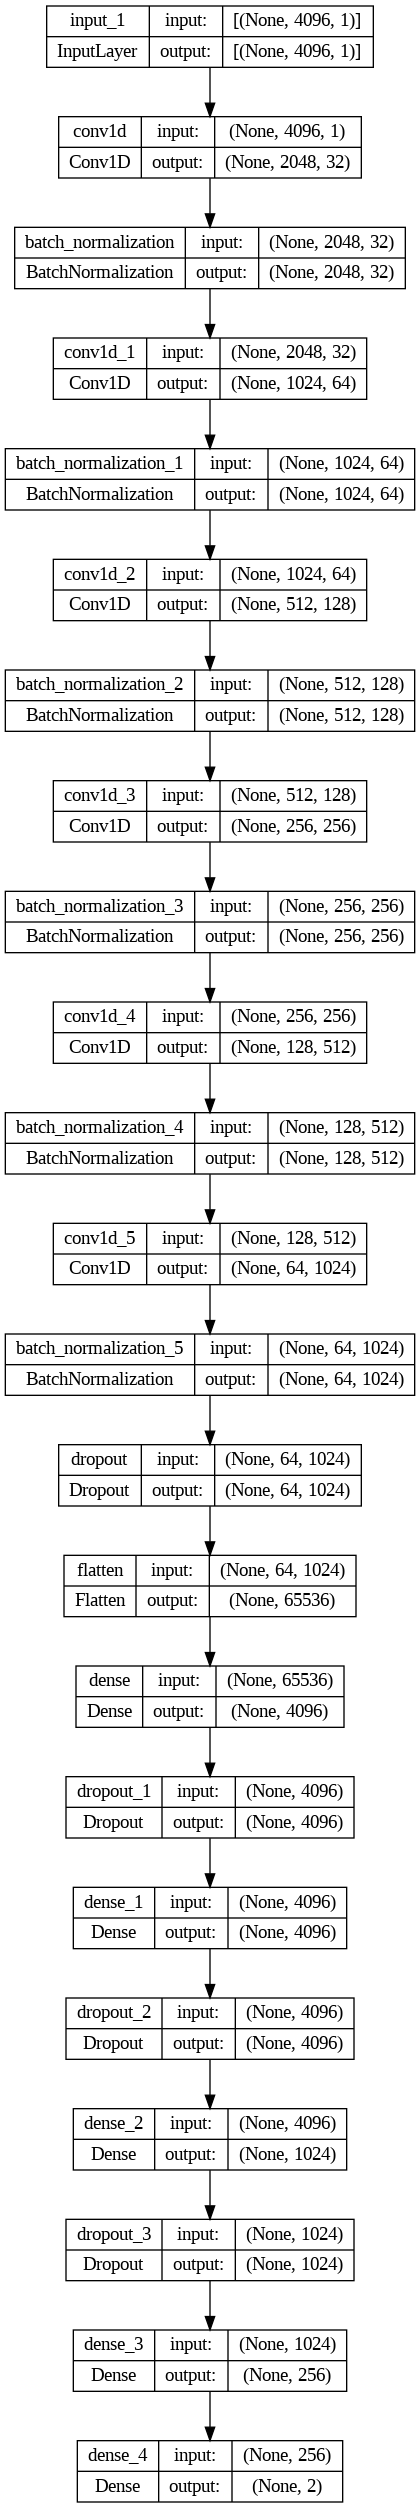

In [14]:
def make_model():

  input_layer = keras.Input(shape=(x_train.shape[1:]))
  x = keras.layers.Conv1D(filters=32, kernel_size=9, strides=2, activation="relu", padding="same")(input_layer)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(filters=64, kernel_size=9, strides=2, activation="relu", padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(filters=128, kernel_size=6, strides=2, activation="relu", padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(filters=256, kernel_size=6, strides=2, activation="relu", padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(filters=512, kernel_size=3, strides=2, activation="relu", padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(filters=1024, kernel_size=3, strides=2, activation="relu", padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(4096, activation="relu")(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(4096, activation="relu", kernel_regularizer=keras.regularizers.L2())(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(1024, activation="relu", kernel_regularizer=keras.regularizers.L2())(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.L2())(x)
  output_layer = keras.layers.Dense(num_classes, activation="softmax")(x)

  return keras.Model(inputs=input_layer, outputs=output_layer)

model = make_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

## Compile&Training

In [15]:
model.compile(optimizer='sgd', 
              loss='binary_crossentropy',
              metrics=['accuracy',
                       keras.metrics.AUC(),
                       keras.metrics.Precision(),
                       keras.metrics.Recall()])

callbacks = [
            #  keras.callbacks.ModelCheckpoint("best_model.h5",
            #                                  monitor="loss",
            #                                  mode="min",
            #                                  save_best_only=True),
             keras.callbacks.EarlyStopping(monitor="val_loss",
                                           mode="min",
                                           patience=10,
                                           restore_best_weights=True),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                               factor=0.2, 
                                               patience=2,
                                               min_lr=0.000001),
            #  keras.callbacks.TensorBoard(log_dir="/content/drive/MyDrive/IDB_drilling_signal/outputs/logs",
            #                              histogram_freq=1,
            #                              write_graph=True, 
            #                              write_images=True)
            ]

history = model.fit(x_train, y_train,
                    validation_split=0.2, 
                    epochs=300, 
                    batch_size=64, 
                    callbacks=callbacks, 
                    shuffle=True)

model.save("/content/drive/MyDrive/IDB_drilling_signal/outputs/model.h5")
np.save("/content/drive/MyDrive/IDB_drilling_signal/outputs/history.npy", history.history, allow_pickle=True)
hist = np.load("/content/drive/MyDrive/IDB_drilling_signal/outputs/history.npy", allow_pickle=True)

Epoch 1/300
241/241 [==============================] - 22s 34ms/step - loss: 58.7824 - accuracy: 0.9063 - auc: 0.9757 - precision: 0.9063 - recall: 0.9063 - val_loss: 63.3623 - val_accuracy: 0.4933 - val_auc: 0.4933 - val_precision: 0.4933 - val_recall: 0.4933 - lr: 0.0100
Epoch 2/300
241/241 [==============================] - 6s 23ms/step - loss: 53.2327 - accuracy: 0.9884 - auc: 0.9984 - precision: 0.9884 - recall: 0.9884 - val_loss: 61.3415 - val_accuracy: 0.4933 - val_auc: 0.4933 - val_precision: 0.4933 - val_recall: 0.4933 - lr: 0.0100
Epoch 3/300
241/241 [==============================] - 6s 23ms/step - loss: 48.3248 - accuracy: 0.9954 - auc: 0.9995 - precision: 0.9954 - recall: 0.9954 - val_loss: 47.6702 - val_accuracy: 0.6898 - val_auc: 0.7200 - val_precision: 0.6898 - val_recall: 0.6898 - lr: 0.0100
Epoch 4/300
241/241 [==============================] - 6s 23ms/step - loss: 43.8818 - accuracy: 0.9972 - auc: 0.9998 - precision: 0.9972 - recall: 0.9972 - val_loss: 41.8117 - val_

## Plot history metrics

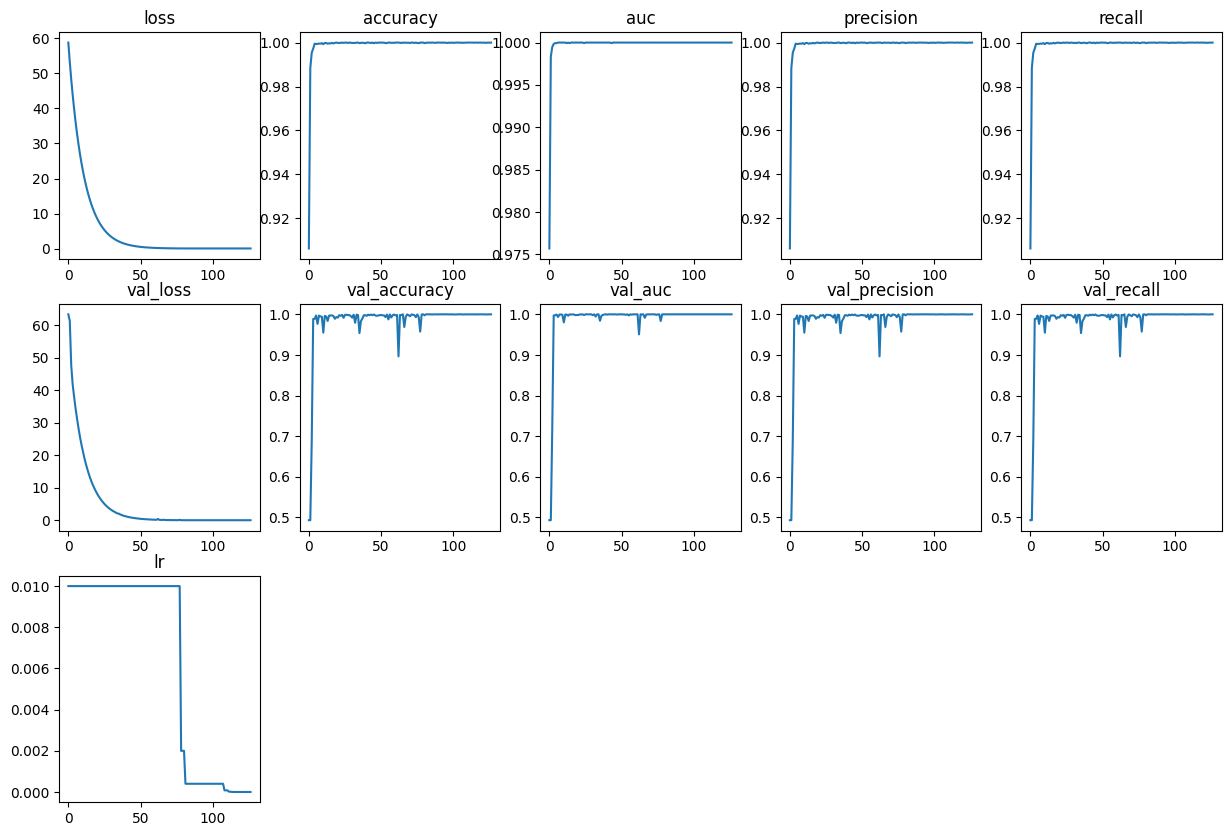

In [17]:
def plot_history_metrics(history):
  
  total_plots = len(history)
  cols = total_plots // 2
  rows = total_plots // cols

  if total_plots % cols != 0:
    rows += 1

  pos = range(1, total_plots + 1)

  plt.figure(figsize=(15, 10))
  for i, (key, value) in enumerate(history.items()):
    plt.subplot(rows, cols, pos[i])
    plt.plot(range(len(value)), value)
    plt.title(str(key))

plot_history_metrics(history.history)

# %load_ext tensorboard
# %tensorboard --logdir "/content/drive/MyDrive/IDB_drilling_signal/output/logs"

## Test-set evaluation

In [18]:
test_loss, test_accuracy, test_auc, test_precision, tes_recall = model.evaluate(x_test, y_test)
print("Test loss", test_loss)
print("Test accuracy", test_accuracy)
print("test_auc", test_auc) 
print("test_precision", test_precision) 
print("tesrecall", tes_recall)

297/297 [==============================] - 2s 5ms/step - loss: 0.0440 - accuracy: 0.9995 - auc: 0.9998 - precision: 0.9995 - recall: 0.9995
Test loss 0.04400920495390892
Test accuracy 0.999473512172699
test_auc 0.9997875690460205
test_precision 0.999473512172699
tesrecall 0.999473512172699


In [21]:
from sklearn.metrics import confusion_matrix

def show_cm(y_true, y_pred):

  cm = confusion_matrix(y_true, y_pred)
  plt.imshow(cm, cmap=plt.cm.Blues)
  plt.xticks([0,1])
  plt.yticks([0,1])
  plt.xlabel("Predict")
  plt.ylabel("True")
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  plt.text(x=0-0.1, y=0, s="TP:"+str(tp), color='black')
  plt.text(x=1-0.1, y=0, s="FN:"+str(fn), color='black')
  plt.text(x=0-0.1, y=1, s="FP:"+str(fp), color='black')
  plt.text(x=1-0.1, y=1, s="TN:"+str(tn), >color='black')
  precision = tp/(tp + fp)
  recall = tp/(tp + tn)
  print("precision:", precision)
  print("recall:", recall)
  plt.show()

y_test_pred = model.predict(x_test)
show_cm(y_test, y_test_pred)

SyntaxError: ignored

# Regression model

In [ ]:
from tensorflow import keras

In [ ]:
# S31h 15:10:51-15:18:26 (15:10:00-15:19:22) [54:-56,1:-1] 455s
# S32h 15:25:33-15:43:18 (15:25:00-15:43:22) [36:-4 ,1:-1] 1065s
# S33b 15:48:20-16:13:46 (15:48:00-16:13:50) [23:-4 ,1:-1] 1526s
# S41h 16:26:25-16:39:33 (16:26:00-16:39:50) [28:-17,1:-1] 788s
# S42h 16:54:57-17:16:30 (16:54:30-17:16:50) [30:-20,1:-1] 1293s
# S43b 17:24:00-18:00:24 (17:24:00-18:00:50) [3:-26 ,1:-1] 2184s

# S32h matFile[0:12*60*RATE] xlsFile[15:31:18-15:43:18]

# S32h = S32h[0:12*60*RATE]
# S41h = S41h[0:12*60*RATE]
# S42h = S42h[0:12*60*RATE]
# S43b = S43b[0:12*60*RATE]

## Data pre-processment

### Enlarge parameter data

In [ ]:
def enlarge_value(array, length):
  L = array.shape[0]
  W = array.shape[1]
  new_section = np.zeros([(L-1)*length, W-1])
  for i in range(L - 1):   
    new_second = np.zeros([length, W-1])
    for j in range(W - 1):
      start_value = float(array[i, j+1])
      end_value = float(array[i+1, j+1])
      new_second[:,j] = np.linspace(start_value, end_value, length + 2)[1:-1]  
    new_section[i*length:(i+1)*length,:] = new_second
  return new_section

S32hY = enlarge_value(S32h_label, RATE)
print(type(S32hY), S32hY.shape)
print(S32hY)

### Pick corresponding signal

In [ ]:
S32hX = S32h[0:len(S32hY)]
print(type(S32hX), S32hX.shape)
print(S32hX)

### Load parameter table

In [ ]:
# S31h 15:10:51-15:18:26 (15:10:00-15:19:22) [54:-56,1:-1] 455s
# S32h 15:25:33-15:43:18 (15:25:00-15:43:22) [36:-4 ,1:-1] 1065s
# S33b 15:48:20-16:13:46 (15:48:00-16:13:50) [23:-4 ,1:-1] 1526s
# S41h 16:26:25-16:39:33 (16:26:00-16:39:50) [28:-17,1:-1] 788s
# S42h 16:54:57-17:16:30 (16:54:30-17:16:50) [30:-20,1:-1] 1293s
# S43b 17:24:00-18:00:24 (17:24:00-18:00:50) [3:-26 ,1:-1] 2184s

# S11 10:58:07-11:01:48 (10:58:00-11:04:15)
# S12 09:16:18-09:18:26 (09:16:00-09:18:50)
# S13 09:21:30-09:23:03 (09:21:00-09:23:50)
# S14 09:45:38-09:46:22 (09:45:00-09:46:50)
# S15 09:49:44-09:50:13 (09:49:00-09:50:50)
# S16 09:53:08- (09:53:00-)
# ......

S32h_dict = {"path":"/content/drive/MyDrive/IDB_drilling_signal/Rock_drilling_signal/experiment1/3-2h.xls", "index1":381, "index2":1102}

In [ ]:
import pandas as pd

def load_table(SIGNAL_dict):
  SIGNAL_pd = pd.read_excel(SIGNAL_dict["path"])
  IPython.display.display(SIGNAL_pd)
  SIGNAL_arr = SIGNAL_pd.values[SIGNAL_dict["index1"]:SIGNAL_dict["index2"],1:-1]
  print(type(SIGNAL_arr), SIGNAL_arr.shape, len(SIGNAL_arr)-1, "s")
  print(SIGNAL_arr)
  return SIGNAL_arr

S32h_label = load_table(S32h_dict)

## Transpose autoencoder

In [ ]:
def make_model():

  input_layer = keras.Input(shape=(x_train.shape[1:]))
  x = keras.Conv1D(filters=64, kernel_size=6, padding="same", strides=2, activation="relu")(x)
  x = keras.Dropout(rate=0.2)(x)
  x = keras.Conv1D(filters=32, kernel_size=6, padding="same", strides=2, activation="relu")(x)
  x = keras.Dropout(rate=0.2)(x)
  x = keras.Conv1D(filters=16, kernel_size=6, padding="same", strides=2, activation="relu")(x)
  x = keras.Dropout(rate=0.2)(x)

  x = keras.Conv1DTranspose(filters=16, kernel_size=6, padding="same", strides=2, activation="relu")(x)
  x = keras.Conv1DTranspose(filters=32, kernel_size=6, padding="same", strides=2, activation="relu")(x)
  x = keras.Conv1DTranspose(filters=64, kernel_size=6, padding="same", strides=2, activation="relu")(x)
  x = keras.Conv1DTranspose(filters=1, kernel_size=6, padding="same")(x)
  output_layer = keras.layers.Dense(num_classes, activation="softmax")(x)

  return keras.Model(inputs=input_layer, outputs=output_layer)

model = make_model()
model.summary()
# keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)]

history = model.fit(x_train, x_train,
                    epochs=300,
                    batch_size=64,                    
                    validation_split=0.2,
                    callbacks=callbacks)

In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
# Checking how the first sequence is learnt
plt.figure(figsize=(18, 6))
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [ ]:
# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

## Self-made autoencoder-2D

In [ ]:
epochs = 50
batch_size = 128

input_size = 1024
hidden_size = 256
code_size = 64
latent_dim = 2

In [ ]:
x = Input(shape=(input_size,))
h1 = Dense(hidden_size, activation='relu')(x)
h2 = Dense(code_size, activation='relu')(h1)
l = Dense(latent_dim, activation='relu')(h2)
h3 = Dense(code_size, activation='relu')(l)
h4 = Dense(hidden_size, activation='relu')(h3)
r = Dense(input_size, activation='sigmoid')(h4)

In [ ]:
autoencoder = Model(x, r)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

In [ ]:
encoder = Model(x, l)
X_train_encoded = encoder.predict(X_train, batch_size=batch_size)
plt.figure()
plt.scatter(X_train_encoded[:, 0], X_train_encoded[:, 1], c=Y_train)
plt.colorbar()
plt.show()

In [ ]:
history = autoencoder.fit(X_train, X_train, 
                          batch_size=batch_size, 
                          epochs=epochs, 
                          verbose=1, 
                          validation_data=(X_test, X_test),
                          )

In [ ]:
encoder = Model(x, l)
X_train_encoded = encoder.predict(X_train, batch_size=batch_size)
plt.figure()
plt.scatter(X_train_encoded[:, 0], X_train_encoded[:, 1], c=Y_train)
plt.colorbar()
plt.show()

## Self-made autoencoder-3D

In [ ]:
epochs = 50
batch_size = 128

input_size = 1024
hidden_size = 256
code_size = 64
latent_dim = 3

In [ ]:
x = Input(shape=(input_size,))
h1 = Dense(hidden_size, activation='relu')(x)
h2 = Dense(code_size, activation='relu')(h1)
l = Dense(latent_dim, activation='relu')(h2)
h3 = Dense(code_size, activation='relu')(l)
h4 = Dense(hidden_size, activation='relu')(h3)
r = Dense(input_size, activation='sigmoid')(h4)

In [ ]:
autoencoder = Model(x, r)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

In [ ]:
# encoder = Model(x, l)
# X_train_encoded = encoder.predict(X_train, batch_size=batch_size)
# plt.figure()
# plt.scatter(X_train_encoded[:, 0], X_train_encoded[:, 1], X_train_encoded[:, 2], c=Y_train)
# plt.colorbar()
# plt.show()

encoder = Model(x, l)
X_train_encoded = encoder.predict(X_train, batch_size=batch_size)

import matplotlib.pyplot as plt
import random

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_train_encoded[:,0], X_train_encoded[:,1], X_train_encoded[:,2], c=Y_train)
plt.show()

In [ ]:
history = autoencoder.fit(X_train, X_train, 
                          batch_size=batch_size, 
                          epochs=epochs, 
                          verbose=1, 
                          validation_data=(X_test, X_test),
                          )

In [ ]:
# encoder = Model(x, l)
# X_train_encoded = encoder.predict(X_train, batch_size=batch_size)
# plt.figure()
# plt.scatter(X_train_encoded[:, 0], X_train_encoded[:, 1], X_train_encoded[:, 2], c=Y_train)
# plt.colorbar()
# plt.show()

encoder = Model(x, l)
X_train_encoded = encoder.predict(X_train, batch_size=batch_size)

import matplotlib.pyplot as plt
import random

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_train_encoded[:,0], X_train_encoded[:,1], X_train_encoded[:,2], c=Y_train)
plt.show()